# **Projet 7 : Indexations automatique d'image **
**Fine tuning VGG16**

Par Adrien Aprile


Authentification :

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [2]:
!ls

datalab


In [7]:
# Installations des librairies utilisées:
!pip install humanize
!pip install GPUtil
!pip install livelossplot

  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/cc/21/68/7a100707fa56b30f1ebb1217d976dea4271a4a5ce55a295df4
Successfully built livelossplot


In [3]:
# Création du répertoire :
### une fois uniquement :
!mkdir -p drive
!google-drive-ocamlfuse drive

print('Files in Drive:')
!ls drive/

Files in Drive:
2016196590810.pdf
2016196590811.pdf
2017150548656.pdf
2018063420107.pdf
acces gdrive folds.ipynb
ALGOFI_APRILE_Adrien.doc
APRILE Adrien_2014-01-06.pdf
APRILE_Adrien_Ingénieur Financier.docx
booking confirmation NB873A (ee12a02f).pdf
booking confirmation NB873A.pdf
cdm do brasil - florian.ods
Colab Notebooks
Cours Maths Krapo 1.zip
CV
D1_resnet50_120_breeds.ipynb
DEBIT AUTHORIZATION.odt
Découvrez.txt
doc CDD AVIVA.rar
Feuille de calcul sans titre.ods
game-strauss.pdf
Groupon-E1E86C276F.pdf
img001.pdf
LDC 2611.jpg
lien api.txt
musique
P010515-03-JV-39-2.pdf
Parcours Data Scientist- Openclassroom Aprile
PFE final.zip
Présentation sans titre.pdf
Projet 7- VGG16.ipynb
Scratchpad
Untitled0.ipynb
Untitled1.ipynb


In [4]:
import os
os.chdir("drive")
os.chdir("Colab Notebooks")
os.chdir("Data-CNN")

Test de la mémoire disponible :


In [6]:
# memory footprint support libraries/code
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 141.3 MB
GPU RAM Free: 11439MB | Used: 0MB | Util   0% | Total 11439MB


Création des train et validation generator : 

In [8]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img

train_dir = './train'
validation_dir = './validation'

nTrain = 679
nVal = 165
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,5))


from keras.applications.resnet50 import preprocess_input
train_datagen = ImageDataGenerator(rescale=1./255,vertical_flip=True,preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)

# Train et validation générator :
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=False
)


Using TensorFlow backend.


Found 679 images belonging to 5 classes.
Found 165 images belonging to 5 classes.


In [10]:
#Export de la liste des classes : 
label_map = (train_generator.class_indices)
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
      pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
save_obj(label_map,"label")

Chargement du CNN VGG16 : 


In [9]:
# Test du VGG16 : 
from keras import applications
vgg_conv = applications.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
for layer in vgg_conv.layers:
    layer.trainable = False
vgg_conv.summary()

58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

Création de la couche fully connected: 

In [11]:
from keras import models,Model
from keras import layers
from keras import optimizers

top_model = models.Sequential()
top_model.add(layers.Flatten(input_shape=vgg_conv.output_shape[1:]))
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dense(5, activation='softmax'))

model = Model(inputs = vgg_conv.input,outputs=top_model(vgg_conv.output))
for layer in model.layers[:-1]:
    layer.trainable = False
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Entrainement du modèle + graph accuracy et logloss : 

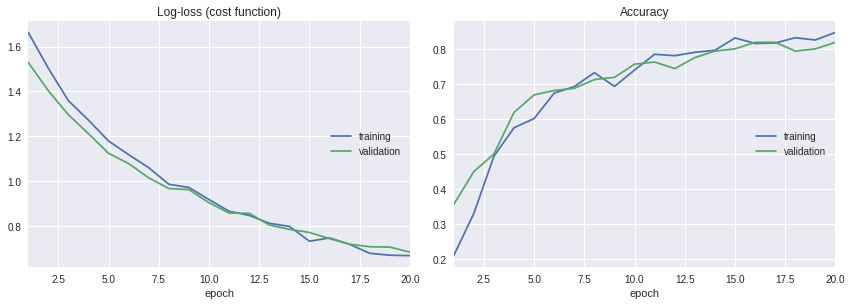

In [12]:
from livelossplot import PlotLossesKeras
batch_size = 32 
epochs = 20
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    steps_per_epoch=679 // batch_size,
    validation_data = validation_generator,
    validation_steps=165 // batch_size,
    callbacks=[PlotLossesKeras()],
    verbose=2
)

Export du modèle entrainé :

In [24]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


Visualisation des résultats du modèles :

Classification Report
                            precision    recall  f1-score   support

        n02086240-Shih-Tzu       0.62      0.90      0.73        29
     n02087046-toy_terrier       0.94      0.97      0.96        34
n02089973-English_foxhound       0.94      0.85      0.89        34
          n02090622-borzoi       0.81      0.62      0.70        34
n02099601-golden_retriever       0.81      0.74      0.77        34

               avg / total       0.83      0.81      0.81       165



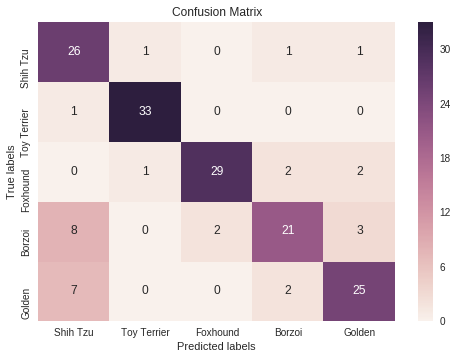

In [23]:
import matplotlib.pyplot as plt


from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

import seaborn as sns
cm = confusion_matrix(validation_generator.classes, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

liste_lab = ['Shih Tzu','Toy Terrier','Foxhound', 'Borzoi','Golden']
liste_lab_rev = list(reversed(liste_lab))
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(liste_lab); ax.yaxis.set_ticklabels(liste_lab_rev);
print('Classification Report')

target_names = list(label_map.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))